In [67]:
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
from pprint import pprint
from sqlalchemy import create_engine
# Google developer API Key
from config import gkey

In [68]:
# importing the Chicago Data Portal - Food Inspections (CSV)
health_inspection_df = pd.read_csv("~/Downloads/Food_Inspections.csv")
health_inspection_df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2552835,JERK VALLEY,JERK VALLEY,2830864.0,Restaurant,All,1556 S PULASKI RD,CHICAGO,IL,60623.0,03/14/2022,License,Not Ready,NaN,41.859014,-87.725106,"(-87.72510564861969, 41.85901391332313)"
1,2549819,ROTI,ROTI,1797796.0,Restaurant,Risk 1 (High),10 S RIVERSIDE PLZ,CHICAGO,IL,60606.0,02/15/2022,Non-Inspection,No Entry,NaN,41.881664,-87.638887,"(-87.63888744408949, 41.881664289382925)"
2,2549607,Buyk,Buyk,2831377.0,NaN,Risk 3 (Low),3621 N WESTERN AVE,CHICAGO,IL,60618.0,02/09/2022,License,Not Ready,NaN,41.947389,-87.688130,"(-87.68813004392258, 41.94738858055078)"
3,2544432,LUCY'S,LUCY'S,2818186.0,Restaurant,Risk 1 (High),1043 N CALIFORNIA AVE,CHICAGO,IL,60622.0,11/18/2021,License,Pass,NaN,41.900640,-87.696678,"(-87.69667798280055, 41.90063956353709)"
4,2546652,SUBWAY,SUBWAY,2488938.0,Restaurant,Risk 1 (High),251 E HURON ST,CHICAGO,IL,60611.0,01/19/2022,Canvass,Pass,NaN,41.894903,-87.620744,"(-87.62074372623964, 41.89490330235543)"


In [69]:
# data cleaning - delete results that are more than 5 years old and restaurants that are out of business
health_inspection_df = health_inspection_df[health_inspection_df['Inspection Date'] >= '1/1/2018']
health_inspection_df = health_inspection_df[health_inspection_df['Results'] != 'Out of Business']
health_inspection_df.head()


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
3,2544432,LUCY'S,LUCY'S,2818186.0,Restaurant,Risk 1 (High),1043 N CALIFORNIA AVE,CHICAGO,IL,60622.0,11/18/2021,License,Pass,NaN,41.900640,-87.696678,"(-87.69667798280055, 41.90063956353709)"
7,2544655,LE PIANO,LE PIANO,2177832.0,Restaurant,Risk 1 (High),6970-6972 N GLENWOOD AVE,CHICAGO,IL,60626.0,11/23/2021,Non-Inspection,No Entry,NaN,42.008814,-87.666354,"(-87.66635391877986, 42.008813688990735)"
8,2544640,EXXON,EXXON,2817855.0,Grocery Store,Risk 3 (Low),3202 W CERMAK RD,CHICAGO,IL,60623.0,11/23/2021,License,Not Ready,NaN,41.851873,-87.705387,"(-87.7053867838598, 41.85187305783481)"
9,2544279,GUILD ROW,GUILD ROW,2665027.0,Restaurant,Risk 1 (High),3128-3138 N ROCKWELL ST,CHICAGO,IL,60618.0,11/17/2021,Canvass,Pass,NaN,41.938710,-87.693069,"(-87.6930685681509, 41.9387095293702)"
10,2537356,MCDONALDS #4655,MCDONALDS #4655,33146.0,Restaurant,Risk 2 (Medium),4334 W 26TH ST,CHICAGO,IL,60623.0,10/27/2021,Short Form Complaint,Pass,NaN,41.844249,-87.732621,"(-87.73262060501526, 41.844249433592466)"


In [32]:
# creating a CSV for the health_inspection_df
# health_inspection_df.to_csv("health_inspection.csv", encoding='utf-8')


In [70]:
# importing the Google API (JSON)
# geocoordinates
target_coordinates = "41.882702, -87.619392" #chicago coordinates
target_search = "hot dogs" #This will return restaurants that offer these types of food
target_radius = 10000
target_type = "restaurant"

# set up a parameters dictionary
params = {
    "location": target_coordinates,
    "keyword": target_search,
    "radius": target_radius,
    "type": target_type,
    "key": gkey
}

# base url
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

# run a request using our params dictionary
response = requests.get(base_url, params=params)
places_data = response.json()


In [71]:
# Google API results
results = []
for result in places_data["results"]:
    results.append({"name": result["name"], "vicinity": result["vicinity"], "rating": result["rating"], "business_status": result["business_status"]})
google_results_df = pd.DataFrame(results)
google_results_df.head()


,name,vicinity,rating,business_status
0,Byron's Hot Dogs,"1701 W Lawrence Ave, Chicago",4.3,OPERATIONAL
1,Chicago's Dog House,"816 W Fullerton Ave, Chicago",4.6,OPERATIONAL
2,Byron's Hot Dog,"1017 W Irving Park Rd, Chicago",4.5,OPERATIONAL
3,Jimmy's Red Hots,"4000 W Grand Ave, Chicago",4.6,OPERATIONAL
4,Jacky's Hot Dogs,"5415 S Pulaski Rd, Chicago",4.7,OPERATIONAL


In [72]:
# Get the remaining 2 pages of results from the google api and add to existing results
for i in range(0,2):
    time.sleep(2)
    params['pagetoken'] = places_data['next_page_token']
    response = requests.get(base_url, params=params)
    places_data = response.json()
    places_data

    results = []
    for result in places_data["results"]:
        results.append({"name": result["name"], "vicinity": result["vicinity"], "rating": result["rating"], "business_status": result["business_status"]})
    google_results_df = pd.concat([google_results_df, pd.DataFrame(results)])

google_results_df.head()


,name,vicinity,rating,business_status
0,Byron's Hot Dogs,"1701 W Lawrence Ave, Chicago",4.3,OPERATIONAL
1,Chicago's Dog House,"816 W Fullerton Ave, Chicago",4.6,OPERATIONAL
2,Byron's Hot Dog,"1017 W Irving Park Rd, Chicago",4.5,OPERATIONAL
3,Jimmy's Red Hots,"4000 W Grand Ave, Chicago",4.6,OPERATIONAL
4,Jacky's Hot Dogs,"5415 S Pulaski Rd, Chicago",4.7,OPERATIONAL


In [73]:
# base url
def search_google(params):
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    # run a request using our params dictionary
    response = requests.get(base_url, params=params)
    places_data = response.json()

    results = []
    for result in places_data["results"]:
        results.append({"name": result["name"], "vicinity": result["vicinity"], "rating": result["rating"], "business_status": result["business_status"]})
    results_df = pd.DataFrame(results)

    for i in range(0,2):
        time.sleep(2)
        params['pagetoken'] = places_data['next_page_token']
        response = requests.get(base_url, params=params)
        places_data = response.json()
        places_data

        results = []
        for result in places_data["results"]:
            results.append({"name": result["name"], "vicinity": result["vicinity"], "rating": result["rating"], "business_status": result["business_status"]})
        results_df = pd.concat([results_df, pd.DataFrame(results)])
    return results_df

google_results_df = search_google({
    "location": "41.882702, -87.619392",
    "keyword": "hot dogs",
    "radius": 10000,
    "type": "restaurant",
    "key": gkey
})

google_results_df = pd.concat([google_results_df , search_google({
    # "location": "41.82908, -87.65083",
    "location": "41.882702, -87.619392",
    "keyword": "hamburgers",
    "radius": 10000,
    "type": "restaurant",
    "key": gkey
})])
google_results_df = pd.concat([google_results_df , search_google({
    "location": "41.882702, -87.619392",
    "keyword": "tacos",
    "radius": 10000,
    "type": "restaurant",
    "key": gkey
})])

google_results_df = pd.concat([google_results_df , search_google({
    "location": "41.882702, -87.619392",
    "keyword": "pizza",
    "radius": 10000,
    "type": "restaurant",
    "key": gkey
})])

google_results_df.head()


,name,vicinity,rating,business_status
0,Byron's Hot Dogs,"1701 W Lawrence Ave, Chicago",4.3,OPERATIONAL
1,Chicago's Dog House,"816 W Fullerton Ave, Chicago",4.6,OPERATIONAL
2,Byron's Hot Dog,"1017 W Irving Park Rd, Chicago",4.5,OPERATIONAL
3,Jimmy's Red Hots,"4000 W Grand Ave, Chicago",4.6,OPERATIONAL
4,Jacky's Hot Dogs,"5415 S Pulaski Rd, Chicago",4.7,OPERATIONAL


In [74]:
# Data cleaning - reset index and remove bad data
google_results_df = google_results_df[google_results_df['vicinity'] != "Chicago"]
google_results_df = google_results_df.drop_duplicates()
google_results_df = google_results_df.reset_index(drop=True)
google_results_df.head()

,name,vicinity,rating,business_status
0,Byron's Hot Dogs,"1701 W Lawrence Ave, Chicago",4.3,OPERATIONAL
1,Chicago's Dog House,"816 W Fullerton Ave, Chicago",4.6,OPERATIONAL
2,Byron's Hot Dog,"1017 W Irving Park Rd, Chicago",4.5,OPERATIONAL
3,Jimmy's Red Hots,"4000 W Grand Ave, Chicago",4.6,OPERATIONAL
4,Jacky's Hot Dogs,"5415 S Pulaski Rd, Chicago",4.7,OPERATIONAL


In [76]:
# putting the two datasets together

merged_dfs = []

for i in range (0, len(google_results_df)):
    address = google_results_df.loc[i, "vicinity"]
    address = address.split(",")[0].upper()
    rating = google_results_df.loc[i, "rating"]
    business_status = google_results_df.loc[i, "business_status"]

    subset_health_inspection_df = health_inspection_df.loc[health_inspection_df['Address'].str.contains(address)].reset_index(drop=True)
    subset_health_inspection_df['Rating'] = pd.Series([rating for x in range(len(subset_health_inspection_df.index))], dtype='float64')
    subset_health_inspection_df['Business Status'] = pd.Series([business_status for x in range(len(subset_health_inspection_df.index))], dtype='str')

    if len(subset_health_inspection_df) > 0:
        merged_dfs.append(subset_health_inspection_df)


merged_df = pd.concat(merged_dfs).reset_index(drop=True)
merged_df.head()


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Rating,Business Status
0,2321197,CHICAGO' S DOG HOUSE INC.,CHICAGO' S DOG HOUSE,1969388.0,Restaurant,Risk 1 (High),816 W FULLERTON AVE,CHICAGO,IL,60614.0,11/06/2019,Canvass,Pass,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.925554,-87.649439,"(-87.64943870806178, 41.92555423106173)",4.6,OPERATIONAL
1,2230027,CHICAGO' S DOG HOUSE INC.,CHICAGO' S DOG HOUSE,1969388.0,Restaurant,Risk 1 (High),816 W FULLERTON AVE,CHICAGO,IL,60614.0,10/22/2018,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.925554,-87.649439,"(-87.64943870806178, 41.92555423106173)",4.6,OPERATIONAL
2,2117088,CHICAGO' S DOG HOUSE INC.,CHICAGO' S DOG HOUSE,1969388.0,Restaurant,Risk 1 (High),816 W FULLERTON AVE,CHICAGO,IL,60614.0,12/12/2017,Canvass Re-Inspection,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.925554,-87.649439,"(-87.64943870806178, 41.92555423106173)",4.6,OPERATIONAL
3,2116668,CHICAGO' S DOG HOUSE INC.,CHICAGO' S DOG HOUSE,1969388.0,Restaurant,Risk 1 (High),816 W FULLERTON AVE,CHICAGO,IL,60614.0,12/05/2017,Canvass,Fail,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...,41.925554,-87.649439,"(-87.64943870806178, 41.92555423106173)",4.6,OPERATIONAL
4,635191,BYRONS KITCHENS,BYRONS KITCHENS,3596.0,Restaurant,Risk 1 (High),1017 W IRVING PARK RD,CHICAGO,IL,60613.0,11/03/2011,Tag Removal,Pass w/ Conditions,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.954368,-87.655224,"(-87.65522418220391, 41.95436836115346)",4.5,OPERATIONAL


In [78]:
# chaginging the column names so they work in PGAdmin - all lowercase, no spaces
merged_df.columns = ["inspection_no", "dba_name", "aka_name", "license_no", "facility_type", "risk", "address", "city", "state", "zip", "inspection_date", "inspection_type", "results", "violations", "latitude", "longitude", "location", "rating", "business_status"]
merged_df.head()
                     

,inspection_no,dba_name,aka_name,license_no,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,rating,business_status
0,2321197,CHICAGO' S DOG HOUSE INC.,CHICAGO' S DOG HOUSE,1969388.0,Restaurant,Risk 1 (High),816 W FULLERTON AVE,CHICAGO,IL,60614.0,11/06/2019,Canvass,Pass,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.925554,-87.649439,"(-87.64943870806178, 41.92555423106173)",4.6,OPERATIONAL
1,2230027,CHICAGO' S DOG HOUSE INC.,CHICAGO' S DOG HOUSE,1969388.0,Restaurant,Risk 1 (High),816 W FULLERTON AVE,CHICAGO,IL,60614.0,10/22/2018,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.925554,-87.649439,"(-87.64943870806178, 41.92555423106173)",4.6,OPERATIONAL
2,2117088,CHICAGO' S DOG HOUSE INC.,CHICAGO' S DOG HOUSE,1969388.0,Restaurant,Risk 1 (High),816 W FULLERTON AVE,CHICAGO,IL,60614.0,12/12/2017,Canvass Re-Inspection,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.925554,-87.649439,"(-87.64943870806178, 41.92555423106173)",4.6,OPERATIONAL
3,2116668,CHICAGO' S DOG HOUSE INC.,CHICAGO' S DOG HOUSE,1969388.0,Restaurant,Risk 1 (High),816 W FULLERTON AVE,CHICAGO,IL,60614.0,12/05/2017,Canvass,Fail,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...,41.925554,-87.649439,"(-87.64943870806178, 41.92555423106173)",4.6,OPERATIONAL
4,635191,BYRONS KITCHENS,BYRONS KITCHENS,3596.0,Restaurant,Risk 1 (High),1017 W IRVING PARK RD,CHICAGO,IL,60613.0,11/03/2011,Tag Removal,Pass w/ Conditions,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.954368,-87.655224,"(-87.65522418220391, 41.95436836115346)",4.5,OPERATIONAL


In [63]:
# choosing just a few columns so I can import to PGAdmin
test_df = merged_df.drop(["inspection_no", "aka_name", "license_no", "facility_type", "risk", "city", "state", "zip", "inspection_type", "latitude", "longitude", "location","rating", "business_status"], axis=1)
test_df
test_df.to_csv("test.csv", encoding='utf-8')


In [79]:
# create a csv file of the merged_df
merged_df.to_csv("merged_restaurants.csv", encoding='utf-8')


In [22]:
merged_df_subset = merged_df.loc[merged_df["Results"] == "Fail"]
# merged_df_subset = merged_df.loc[merged_df["Results"] != "Pass"]
merged_df_subset
counts = merged_df_subset.Address.value_counts()
plot_df = []
for address in pd.unique(merged_df['Address']):
    count = 0
    if address in counts.index:
        count = counts[address]

    plot_df.append({
        'address': address,
        'failed health inspections': count,
        'name': merged_df.loc[merged_df['Address'] == address]['DBA Name'].iloc[0],
        'rating': merged_df.loc[merged_df['Address'] == address]['Rating'].iloc[0],
    })
plot_df = pd.DataFrame(plot_df)
plot_df


,address,failed health inspections,name,rating
0,636 N ASHLAND AVE,2,DUKS RED HOTS,4.4
1,804 N RUSH ST,0,DOWNTOWN DOGS,4.9
2,2622 N CLARK ST,0,THE WEINER'S CIRCLE,4.4
3,1534 N WELLS ST,0,THE DOG HOUSE GRILL,3.9
4,100 W ONTARIO ST,6,PORTILLO'S HOT DOGS,4.4
5,2258 W CHICAGO AVE,0,PHIL'S LAST STAND,4.4
6,3021 N BROADWAY,0,FLUB A DUB CHUB'S,4.7
7,1876 N DAMEN AVE,2,GEORGE'S HOT DOG,4.4
8,1017 W IRVING PARK RD,0,BYRONS KITCHENS,4.5
9,1701 W LAWRENCE AVE,3,BYRONS HOT DOG INC,4.3


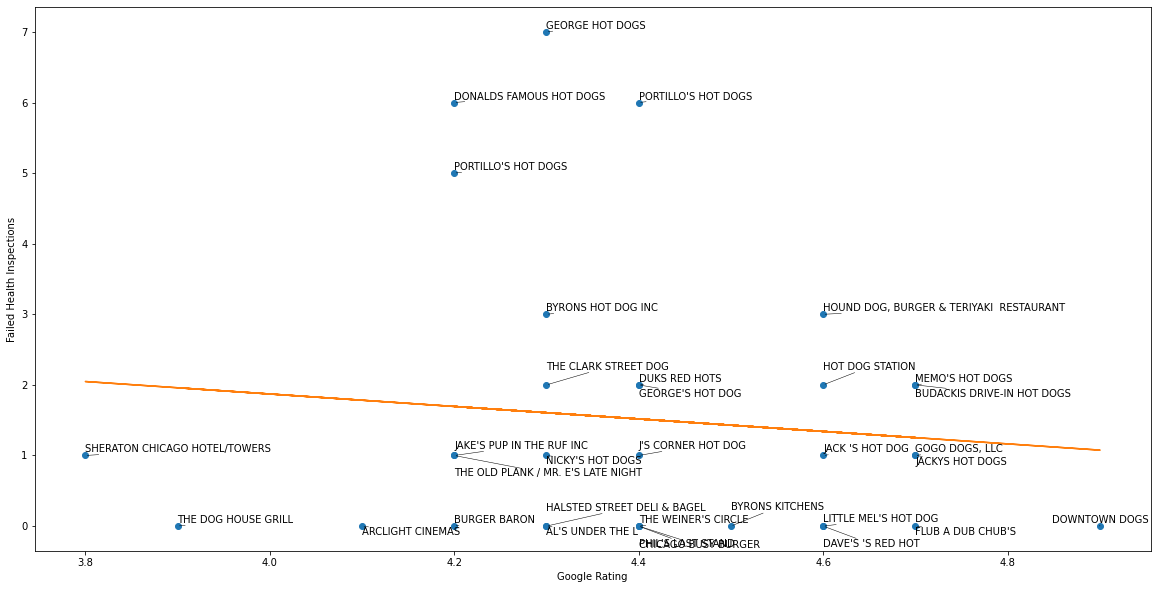

In [23]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

x = plot_df['rating'].to_numpy()
y = plot_df['failed health inspections'].to_numpy()
plt.xlabel("Google Rating")
plt.ylabel("Failed Health Inspections")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'o', x, p(x), "-")

texts = []
for row in plot_df.iterrows():
    row = row[1]
    texts.append(plt.text(row['rating'], row['failed health inspections'], row['name']))

adjust_text(
    texts,
    x=x,
    y=y,
    autoalign='y',
    ha='left',
    only_move={'points':'y', 'text':'y'},
    force_points=0.15,
    arrowprops=dict(arrowstyle="-", lw=0.5)
)
plt.rcParams["figure.figsize"] = (20,10)

plt.show()
